In [1]:
import argparse
import numpy as np
import torch
from torch.autograd import Variable

import pyro
from pyro.distributions import Uniform, Normal
from pyro.infer import Importance, Marginal, SVI
from pyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('oceans16')

%matplotlib inline

In [2]:
little_g = 9.8 # m/s/s
mu0 = 0.12 # coefficient of friction
time_measurement_sigma = 0.02 # observation noise in s

In [11]:
# Forward simulator

def simulate(mu, length=2.0, phi=np.pi/6.0, dt=0.005, noise_sigma=None):
    T = Variable(torch.zeros(1))
    velocity = Variable(torch.zeros(1))
    displacement = Variable(torch.zeros(1))
    acceleration = Variable(torch.Tensor([little_g * np.sin(phi)])) - \
    Variable(torch.Tensor([little_g * np.cos(phi)])) * mu
    
    if acceleration.data.numpy() <= 0.0: # if friction too large box won't slide biotch
        return Variable(torch.Tensor([1.0e5]))
    
    while displacement.data.numpy() < length:
        displacement += velocity * dt
        velocity += acceleration * dt
        T += dt
        
    if noise_sigma is None:
        return T
    else:
        return T + Variable(noise_sigma * torch.randn(1))

In [24]:
def analytic_T(mu, length=2.0, phi=np.pi/6.0):
    numerator = 2.0*length
    denominator = little_g * (np.sin(phi) - mu*np.cos(phi))
    return np.sqrt(numerator / denominator)

In [32]:
N_obs = 20
observed_data = torch.cat([simulate(mu0, noise_sigma=time_measurement_sigma)
                         for _ in range(N_obs)])
observed_mean = np.mean([T.data.numpy() for T in observed_data])

In [39]:
def model(observed_data):
    mu_prior = Uniform(Variable(torch.zeros(1)), Variable(torch.ones(1)))
    mu = pyro.sample("mu", mu_prior)
    
    def observe_T(T_obs, obs_name):
        T_simulated = simulate(mu)
        T_obs_dist = Normal(T_simulated,
                            Variable(torch.Tensor([time_measurement_sigma])))
        pyro.observe(obs_name, T_obs_dist, T_obs)
    
    for i, T_obs in enumerate(observed_data):
        observe_T(T_obs, "obs_%d" % i)
        
    return mu        

In [40]:
num_samples = 500
posterior = Importance(model, guide=None, num_samples=num_samples)
marginal = Marginal(posterior)
print("doing improtance sampling...")
posterior_samples = [marginal(observed_data) for i in range(num_samples)]

doing improtance sampling...


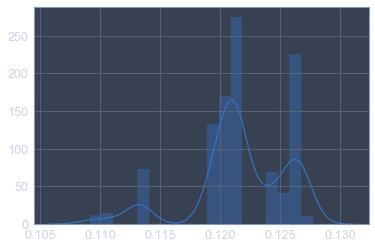

In [43]:
sns.distplot(torch.cat(posterior_samples).data.numpy())

In [44]:
posterior_mean = torch.mean(torch.cat(posterior_samples))
posterior_std = torch.std(torch.cat(posterior_samples), 0)

In [45]:
inferred_mu = posterior_mean.data.numpy()
inferred_mu_uncertainty = posterior_std.data.numpy()
print("the coefficient of friction inferred by pyro is %.3f +- %.3f" %
          (inferred_mu, inferred_mu_uncertainty))

the coefficient of friction inferred by pyro is 0.122 +- 0.004


In [47]:
print("the mean observed descent time in the dataset is: %.4f seconds" % observed_mean)
print("the (forward) simulated descent time for the inferred (mean) mu is: %.4f seconds" %
      simulate(posterior_mean).data.numpy())
print(("disregarding measurement noise, elementary calculus gives the descent time\n" +
       "for the inferred (mean) mu as: %.4f seconds") % analytic_T(posterior_mean.data.numpy()))

the mean observed descent time in the dataset is: 1.0196 seconds
the (forward) simulated descent time for the inferred (mean) mu is: 1.0200 seconds
disregarding measurement noise, elementary calculus gives the descent time
for the inferred (mean) mu as: 1.0170 seconds


In [53]:
observed_data

Variable containing:
 1.0179
 1.0233
 1.0088
 0.9879
 1.0171
 0.9971
 1.0256
 1.0453
 1.0019
 1.0313
 1.0210
 1.0444
 1.0077
 1.0110
 1.0418
 1.0086
 1.0210
 1.0387
 1.0069
 1.0344
[torch.FloatTensor of size 20]

In [54]:
simulate(mu0)

Variable containing:
 1.0200
[torch.FloatTensor of size 1]